# RQ 2.
Does training a set of one-vs-all classifiers(OvRs) with negative samples improve
- the closed-set performance (OvRs vs. Entropic Open-set Loss)
- the open-set performance (OvRs vs. Entropic Open-set Loss)

of multiclass classification task?

In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import os
import re
import itertools
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [74]:
approaches_abbr = {'SoftMax':'SM','EOS':'EOS','MultiBinary':'BCE','OpenSetOvR':'OSOvR'}
approaches_full = {'SoftMax':'SoftMax','EOS':'Enropic Open-Set Loss','MultiBinary':'Multi BCE Loss','OpenSetOvR':'Open-Set One-vs-Rest Classifiers'}
seeds = [42,43,44,45,46,47,48,49,50,51]
num_classes = 10

CMAP = mpl.color_sequences['tab10']

## Functions

In [75]:
def list_model_files(folder_path):
    # List to store .model files
    model_files = []

    # Iterate over all files in the given folder
    for file_name in os.listdir(folder_path):
        # Check if the file ends with .model
        if file_name.endswith('.model'):
            model_files.append(file_name)

    return model_files


In [76]:
class eval_results():
    def __init__(self, folder_path):

        self.test_neg_gt = np.load(os.path.join(folder_path, 'pred', 'test_neg_gt.npy'))
        self.test_neg_logits = np.load(os.path.join(folder_path, 'pred', 'test_neg_logits.npy'))
        self.test_neg_probs = np.load(os.path.join(folder_path, 'pred', 'test_neg_probs.npy'))

        self.test_unkn_gt = np.load(os.path.join(folder_path, 'pred', 'test_unkn_gt.npy'))
        self.test_unkn_logits = np.load(os.path.join(folder_path, 'pred', 'test_unkn_logits.npy'))
        self.test_unkn_probs = np.load(os.path.join(folder_path, 'pred', 'test_unkn_probs.npy'))

        self.ccr = np.load(os.path.join(folder_path, 'oscr', 'ccr.npy'))
        self.fpr_neg = np.load(os.path.join(folder_path, 'oscr', 'fpr_neg.npy'))
        self.fpr_unkn = np.load(os.path.join(folder_path, 'oscr', 'fpr_unkn.npy'))


In [77]:
def recall_oscr_results(which='MultiBinary', arch='LeNet_plus_plus', dataset='SmallScale', seed=-1, is_verbose=True):
    if seed == -1:
        root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{dataset}/eval_{arch}/{which}/oscr'
    else:
        root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{dataset}/_s{seed}/eval_{arch}/{which}/oscr'
    if is_verbose:
        print(root_path, which)
    oscr_results = [
        np.load(os.path.join(root_path,'ccr.npy')),
        np.load(os.path.join(root_path,'fpr_neg.npy')),
        np.load(os.path.join(root_path,'fpr_unkn.npy')),
        ]
    return oscr_results

In [78]:
def get_training_log(scale, arch, approach, log_item = 'Loss/train'):
    log_path = f"./_models/{scale}/_s42/{arch}/{approach}/Logs"
    onlyfiles = [f for f in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, f))]
    log_file = onlyfiles[-1]

    event_acc = EventAccumulator(os.path.join(log_path, log_file))
    event_acc.Reload()

    logs = [e.value for e in event_acc.Scalars(log_item)]

    return logs

In [79]:
def CCR_at_FPR(CCR, FPR, fpr_values=[1e-4,1e-3,1e-2,1e-1,1]):
    """Computes CCR values for the desired FPR values, if such FPR values can be reached."""

    ccrs = []
    zero = np.zeros(FPR.shape)
    for desired_fpr in fpr_values:
        # get the FPR value that is closest, but above the current threshold
        candidates = np.nonzero(np.maximum(desired_fpr - FPR, zero))[0]
        if len(candidates) > 0:
            # there are values above threshold
            ccrs.append(CCR[candidates[0]])
        else:
            # the desired FPR cannot be reached
            ccrs.append(np.nan)

    return ccrs, fpr_values

In [81]:
def deef_feat_viz_sample_detail(data_info:list, sigma:int):

    # To get a shared axis range
    max_val = 0 
    for idx, data in  enumerate(data_info):
        scale, arch, appr = data['info']
        eval_root = f'./_results/{scale}/_s42/eval_{arch}/{appr}'

        # Load evaluation data
        test_neg_feats = np.load(os.path.join(eval_root,'pred','test_neg_feats.npy'))
        test_unkn_feats = np.load(os.path.join(eval_root,'pred','test_unkn_feats.npy'))

        max_val_cand = max(np.max(np.abs(test_neg_feats)), np.max(np.abs(test_unkn_feats)))
        if max_val_cand > max_val:
            max_val = max_val_cand

    num_r = 3
    num_c = len(data_info)
    fig, ax = plt.subplots(num_r, num_c, figsize=(num_c*4,num_r*4), sharex=True, sharey=True)

    for idx, data in enumerate(data_info):
        
        scale, arch, appr = data['info']
        network_folder = f'_models/{scale}/_s42/{arch}/{appr}'
        eval_root = f'./_results/{scale}/_s42/eval_{arch}/{appr}'

        # Load evaluation data
        test_neg_feats = np.load(os.path.join(eval_root,'pred','test_neg_feats.npy'))
        test_neg_gt = np.load(os.path.join(eval_root,'pred','test_neg_gt.npy'))
        test_unkn_feats = np.load(os.path.join(eval_root,'pred','test_unkn_feats.npy'))
        test_unkn_gt = np.load(os.path.join(eval_root,'pred','test_unkn_gt.npy'))
        
        known = test_neg_gt != -1
        negative = test_neg_gt == -1
        unknown = test_unkn_gt == -1

        known_feats = test_neg_feats[known,:]
        negative_feats = test_neg_feats[negative,:]
        unknown_feats = test_unkn_feats[unknown,:]

        # Prepare the model
        net = architectures.__dict__['LeNet_plus_plus'](use_BG=False,num_classes=10,final_layer_bias=False,)
        network_file = os.path.join(network_folder, f"{appr}.model")
        checkpoint = torch.load(network_file, map_location=torch.device('cpu')) 
        net.load_state_dict(checkpoint)

        # Generate heatmap data
        xy_range = [-max_val, max_val]
        x = np.linspace(xy_range[0] * 1.2, xy_range[1] * 1.2, 1000)
        y = np.linspace(xy_range[0] * 1.2, xy_range[1] * 1.2, 1000)
        pnts = np.array(list(itertools.chain(itertools.product(x, y))))
        pnts = torch.tensor(pnts).float()
        result = net.deep_feature_forward(pnts)
        if appr == 'MultiBinary':
            probs = F.sigmoid(result).detach()
        elif appr == 'OpenSetOvR':
            osovr_act = losses.OpenSetOvR(sigma)
            probs = osovr_act(result, net.fc2.weight.data).detach()
        else:
            probs = F.softmax(result, dim=1).detach()
        probs = torch.max(probs, dim=1).values

        # ----------------------------------------------------
        # Heatmap plot
        # ----------------------------------------------------
        for j in range(num_r):
            heat_map = ax[j,idx].pcolormesh(
                x,
                y,
                np.array(probs).reshape(1000, 1000).transpose(),
                cmap='gray',
                rasterized=True,
                shading="auto",
                vmin=0.0,
                vmax=1.0,
            )

        # ----------------------------------------------------
        # Testset scatter plot : Known / Neg / Unknown
        # ----------------------------------------------------
        for c in range(10):
            known_feats_c = known_feats[test_neg_gt[known] == c,:]
            ax[0,idx].scatter(known_feats_c[:,0], known_feats_c[:,1], label = c, s=1, color=CMAP[c])
        ax[1,idx].scatter(negative_feats[:,0], negative_feats[:,1], label = 'Negative', s=1, color='r', marker='*')
        ax[2,idx].scatter(unknown_feats[:,0], unknown_feats[:,1], label = 'Unknown', s=1, color='r', marker='*')

        # ----------------------------------------------------
        # Testset scatter plot : Known / Neg / Unknown
        # ----------------------------------------------------
        ax[0,idx].set_title(f"{data['label']} - Known Samples")
        ax[1,idx].set_title(f"{data['label']} - Negatives")
        ax[2,idx].set_title(f"{data['label']} - Unknowns")

        ax[0,idx].set_xlim(xy_range[0],xy_range[1])
        ax[0,idx].set_ylim(xy_range[0],xy_range[1])
        ax[1,idx].set_xlim(xy_range[0],xy_range[1])
        ax[1,idx].set_ylim(xy_range[0],xy_range[1])
        ax[2,idx].set_xlim(xy_range[0],xy_range[1])
        ax[2,idx].set_ylim(xy_range[0],xy_range[1])

        ax[0,idx].grid(True)
        ax[1,idx].grid(True)
        ax[2,idx].grid(True)

    fig.tight_layout()

## Feature Space Viz

In [82]:
SIGMA = 6

eos_data_info = [
    {'info':['SmallScale', 'LeNet_plus_plus_neg0', 'EOS'], 'label': 'EOS (w/o Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[0]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg1k', 'EOS'], 'label': 'EOS (w/ 1k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[1]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg5k', 'EOS'], 'label': 'EOS (w/ 5k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[2]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg10k', 'EOS'], 'label': 'EOS (w/ 10k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[3]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg20k', 'EOS'], 'label': 'EOS (w/ 20k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[4]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg30k', 'EOS'], 'label': 'EOS (w/ 30k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[5]},
    {'info':['SmallScale', 'LeNet_plus_plus', 'EOS'], 'label': 'EOS (w/ All Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[6]},
]

osovr_data_info = [
    {'info':['SmallScale', 'LeNet_plus_plus', 'OpenSetOvR'], 'label': 'OSOvR (w/o Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg1k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 1k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg5k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 5k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[2]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg10k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 10k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[3]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg20k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 20k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[4]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg30k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 30k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[5]},
    {'info':['SmallScale', 'LeNet_plus_plus_negAll', 'OpenSetOvR'], 'label': 'OSOvR (w/ All Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[6]},
]

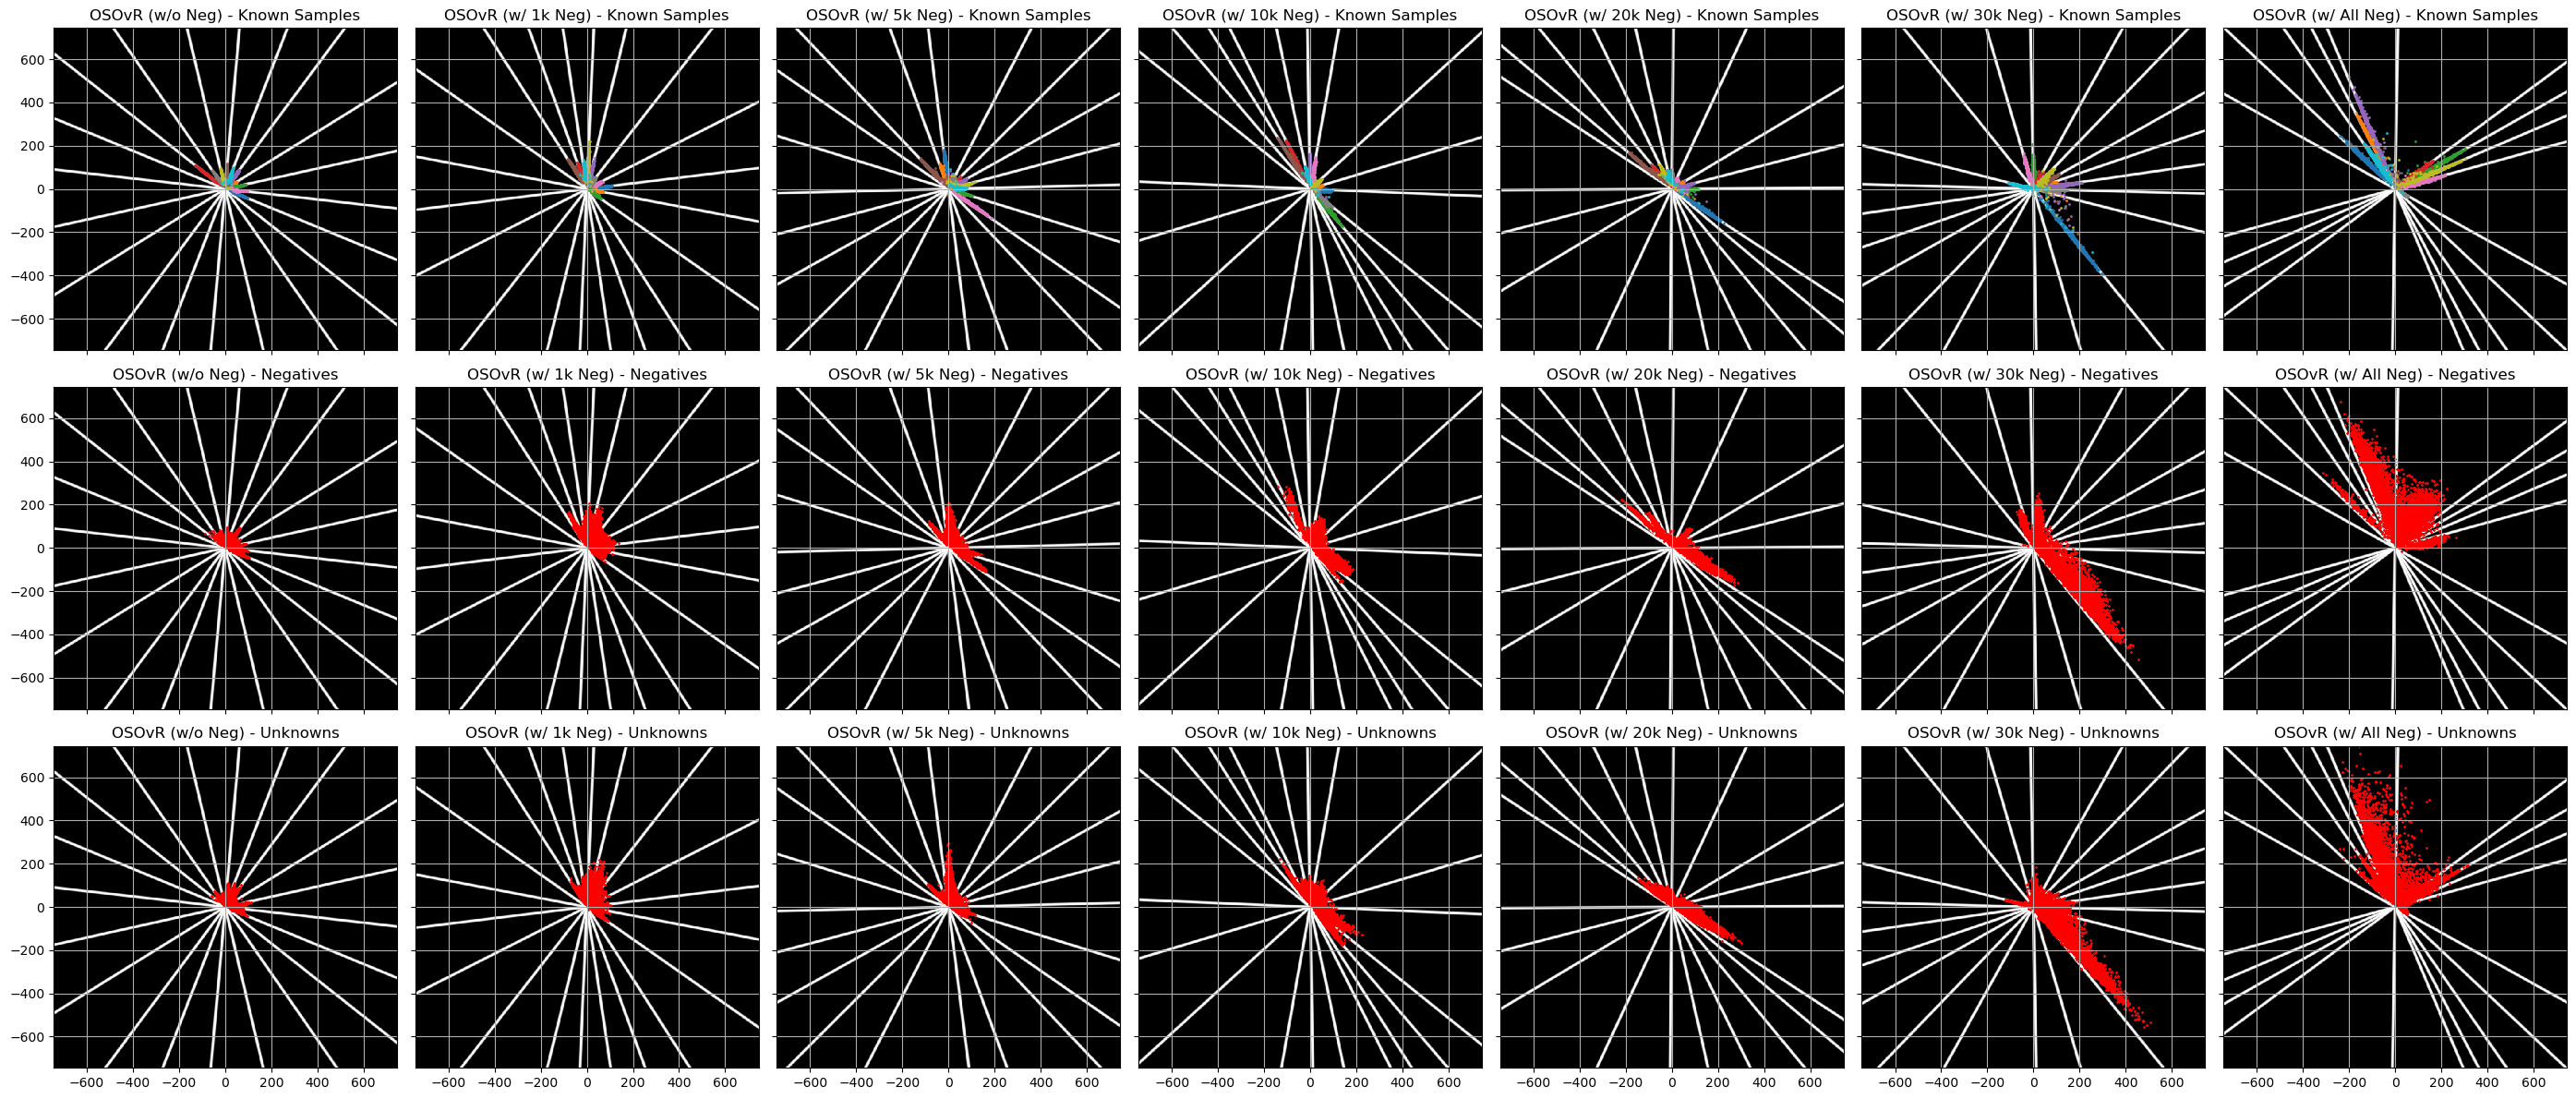

In [83]:
deef_feat_viz_sample_detail(data_info=osovr_data_info, sigma=SIGMA)

## OSCR and CCR@FPR

In [84]:
eos_data_info = [
    {'info':['SmallScale', 'LeNet_plus_plus_neg0', 'EOS'], 'label': 'EOS (w/o Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[0]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg1k', 'EOS'], 'label': 'EOS (w/ 1k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[1]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg5k', 'EOS'], 'label': 'EOS (w/ 5k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[2]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg10k', 'EOS'], 'label': 'EOS (w/ 10k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[3]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg20k', 'EOS'], 'label': 'EOS (w/ 20k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[4]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg30k', 'EOS'], 'label': 'EOS (w/ 30k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[5]},
    {'info':['SmallScale', 'LeNet_plus_plus', 'EOS'], 'label': 'EOS (w/ All Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[6]},
]

osovr_data_info = [
    {'info':['SmallScale', 'LeNet_plus_plus', 'OpenSetOvR'], 'label': 'OSOvR (w/o Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg1k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 1k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg5k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 5k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[2]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg10k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 10k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[3]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg20k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 20k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[4]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg30k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 30k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[5]},
    {'info':['SmallScale', 'LeNet_plus_plus_negAll', 'OpenSetOvR'], 'label': 'OSOvR (w/ All Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[6]},
]


eos_vs_osovr_data_info = [
    {'info':['SmallScale', 'LeNet_plus_plus_neg0', 'EOS'], 'label': 'EOS (w/o Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[0]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg5k', 'EOS'], 'label': 'EOS (w/ 5k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[2]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg20k', 'EOS'], 'label': 'EOS (w/ 20k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[4]},
    {'info':['SmallScale', 'LeNet_plus_plus', 'EOS'], 'label': 'EOS (w/ All Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[6]},
    {'info':['SmallScale', 'LeNet_plus_plus', 'OpenSetOvR'], 'label': 'OSOvR (w/o Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg5k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 5k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[2]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg20k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 20k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[4]},
    {'info':['SmallScale', 'LeNet_plus_plus_negAll', 'OpenSetOvR'], 'label': 'OSOvR (w/ All Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[6]},
]

data_info = eos_vs_osovr_data_info       #   eos_data_info       osovr_data_info       eos_vs_osovr_data_info

In [85]:
results = []
FPR_vals_all = np.linspace(1e-4,1,10**4)
FPR_vals = [1e-4,1e-3,1e-2,1e-1,1]

results = []
for item in data_info:

    info = item['info']
    oscr_neg_res_all, oscr_neg_res = [], []
    oscr_unkn_res_all, oscr_unkn_res = [], []

    for s in seeds:

        ccr, fpr_neg, fpr_unkn = recall_oscr_results(which=info[2], arch=info[1], dataset=info[0], seed = s, is_verbose= s==seeds[0] or s==seeds[-1])

        ccrs_all, _ = CCR_at_FPR(ccr, fpr_neg, FPR_vals_all)
        ccrs, _ = CCR_at_FPR(ccr, fpr_neg, FPR_vals)
        oscr_neg_res_all.append(ccrs_all)
        oscr_neg_res.append(ccrs)

        ccrs_all, _ = CCR_at_FPR(ccr, fpr_unkn, FPR_vals_all)
        ccrs, _ = CCR_at_FPR(ccr, fpr_unkn, FPR_vals)
        oscr_unkn_res_all.append(ccrs_all)
        oscr_unkn_res.append(ccrs)

    results.append([(np.nanmean(oscr_neg_res_all,axis=0), np.nanmean(oscr_neg_res,axis=0), np.nanstd(oscr_neg_res,axis=0)),
                    (np.nanmean(oscr_unkn_res_all,axis=0), np.nanmean(oscr_unkn_res,axis=0), np.nanstd(oscr_unkn_res,axis=0))])

/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_plus_plus_neg0/EOS/oscr EOS


/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_plus_plus_neg0/EOS/oscr EOS
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_plus_plus_neg5k/EOS/oscr EOS
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_plus_plus_neg5k/EOS/oscr EOS
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_plus_plus_neg20k/EOS/oscr EOS
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_plus_plus_neg20k/EOS/oscr EOS


/tmp/ipykernel_1175240/2691088014.py:27: RuntimeWarning: Mean of empty slice
  (np.nanmean(oscr_unkn_res_all,axis=0), np.nanmean(oscr_unkn_res,axis=0), np.nanstd(oscr_unkn_res,axis=0))])
/home/user/hkim/miniconda3/envs/os-multi-binary/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_plus_plus/EOS/oscr EOS
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_plus_plus/EOS/oscr EOS
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_plus_plus/OpenSetOvR/oscr OpenSetOvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_plus_plus/OpenSetOvR/oscr OpenSetOvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_plus_plus_neg5k/OpenSetOvR/oscr OpenSetOvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_plus_plus_neg5k/OpenSetOvR/oscr OpenSetOvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_plus_plus_neg20k/OpenSetOvR/oscr OpenSetOvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_plus_plus_neg20k/OpenSetOvR/oscr OpenSetOvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_plus_plus_negAll/OpenSetOvR/oscr OpenSet

In [86]:
results_plot = results
infos_plot = data_info

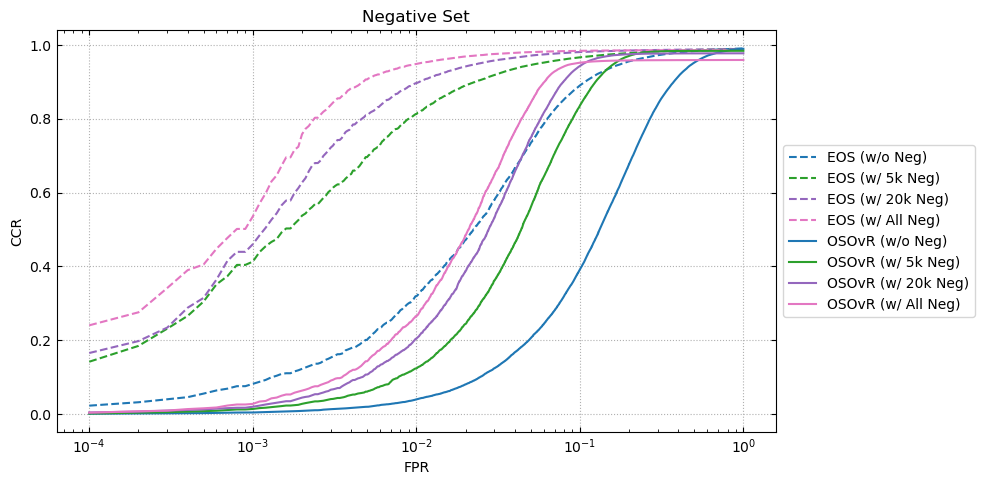

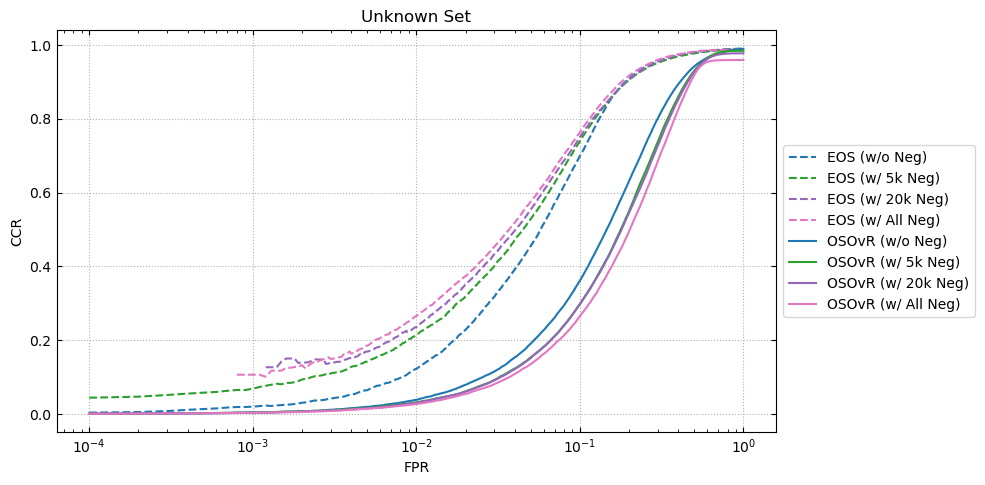

In [87]:
# plot with Negatives
plt.figure(figsize=(10,5))
for idx, res in enumerate(results_plot):
    plt.semilogx(FPR_vals_all, res[0][0], label=infos_plot[idx]['label'], alpha=1, linestyle=infos_plot[idx]['linestyle'], color = infos_plot[idx]['color'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("FPR")
plt.ylabel("CCR")
plt.title("Negative Set")
plt.tight_layout()
plt.tick_params(direction='in', which='both', top=True, right=True)
plt.grid(which='major', linestyle=':')
# plt.savefig(root.joinpath('oscr_neg.png'), bbox_inches="tight") 

# plot with Unknowns
plt.figure(figsize=(10,5))
for idx, res in enumerate(results_plot):
    plt.semilogx(FPR_vals_all, res[1][0], label=infos_plot[idx]['label'], alpha=1, linestyle=infos_plot[idx]['linestyle'], color = infos_plot[idx]['color'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("FPR")
plt.ylabel("CCR")
plt.title("Unknown Set")
plt.tight_layout()
plt.tick_params(direction='in', which='both', top=True, right=True)
plt.grid(which='major', linestyle=':')
# plt.savefig(root.joinpath('oscr_unkn.png'), bbox_inches="tight") 

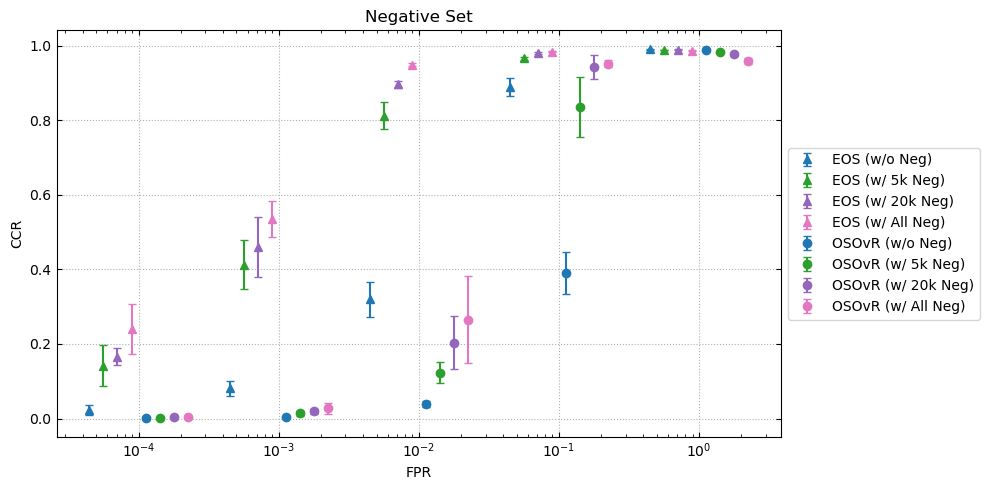

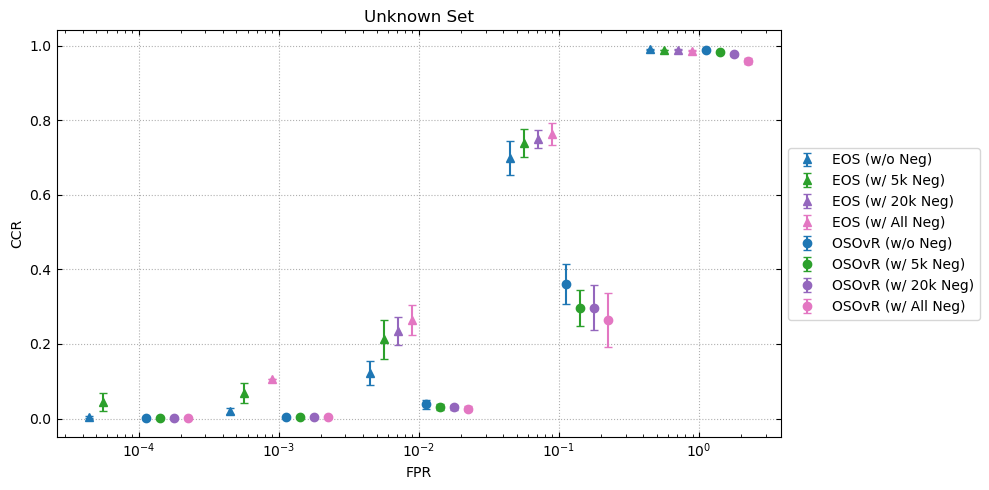

In [88]:
# trans = np.arange(len(results))
# trans = (trans-np.mean(trans))*0.4 + 1

trans = np.arange(len(results_plot)) * 0.1
trans = 10 ** (trans-np.mean(trans))

fig, ax = plt.subplots(figsize=(10,5))
for idx, res in enumerate(results_plot):
    er1 = ax.errorbar([v * trans[idx] for v in FPR_vals], res[0][1], yerr=res[0][2], linestyle="none", capsize=3, 
                      marker=infos_plot[idx]['marker'], label=infos_plot[idx]['label'], color =infos_plot[idx]['color'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("FPR")
plt.xscale('log')
plt.ylabel("CCR")
plt.title("Negative Set")
plt.tick_params(direction='in', which='both', top=True, right=True)
plt.grid(which='major', linestyle=':')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(10,5))
for idx, res in enumerate(results_plot):
    er1 = ax.errorbar([v * trans[idx] for v in FPR_vals], res[1][1], yerr=res[1][2], linestyle="none", capsize=3,
                      marker=infos_plot[idx]['marker'], label=infos_plot[idx]['label'], color =infos_plot[idx]['color'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("FPR")
plt.xscale('log')
plt.ylabel("CCR")
plt.title("Unknown Set")
plt.tick_params(direction='in', which='both', top=True, right=True)
plt.grid(which='major', linestyle=':')
plt.tight_layout()


In [89]:
print("CCR@FPR (Testset: Known + Negatives)")
print(*FPR_vals, sep='\t')
for idx, res in enumerate(results_plot):
    print(*[f"{x:.4f}" for x in res[0][1]], sep='\t')
print()
print("CCR@FPR (Testset: Known + Unknowns)")
print(*FPR_vals, sep='\t')
for idx, res in enumerate(results_plot):
    print(*[f"{x:.4f}" for x in res[1][1]], sep='\t')

CCR@FPR (Testset: Known + Negatives)
0.0001	0.001	0.01	0.1	1
0.0225	0.0815	0.3193	0.8903	0.9907
0.1416	0.4127	0.8128	0.9666	0.9890
0.1652	0.4599	0.8965	0.9810	0.9891
0.2402	0.5352	0.9485	0.9843	0.9869
0.0006	0.0040	0.0391	0.3907	0.9898
0.0012	0.0135	0.1233	0.8350	0.9843
0.0040	0.0196	0.2036	0.9430	0.9776
0.0035	0.0273	0.2649	0.9521	0.9595

CCR@FPR (Testset: Known + Unknowns)
0.0001	0.001	0.01	0.1	1
0.0034	0.0196	0.1220	0.6988	0.9907
0.0439	0.0682	0.2126	0.7387	0.9890
nan	nan	0.2351	0.7494	0.9891
nan	0.1062	0.2650	0.7629	0.9869
0.0006	0.0032	0.0380	0.3606	0.9898
0.0005	0.0039	0.0311	0.2974	0.9843
0.0005	0.0029	0.0297	0.2971	0.9776
0.0005	0.0027	0.0265	0.2645	0.9595


## Probability distribution

In [90]:
eos_vs_osovr_data_info = [
    {'info':['SmallScale', 'LeNet_plus_plus_neg0', 'EOS'], 'label': 'EOS (w/o Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[0]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg5k', 'EOS'], 'label': 'EOS (w/ 5k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[2]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg20k', 'EOS'], 'label': 'EOS (w/ 20k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[4]},
    {'info':['SmallScale', 'LeNet_plus_plus', 'EOS'], 'label': 'EOS (w/ All Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[6]},
    {'info':['SmallScale', 'LeNet_plus_plus', 'OpenSetOvR'], 'label': 'OSOvR (w/o Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg5k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 5k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[2]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg20k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 20k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[4]},
    {'info':['SmallScale', 'LeNet_plus_plus_negAll', 'OpenSetOvR'], 'label': 'OSOvR (w/ All Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[6]},
]

data_info = eos_vs_osovr_data_info       #   eos_data_info       osovr_data_info       eos_vs_osovr_data_info

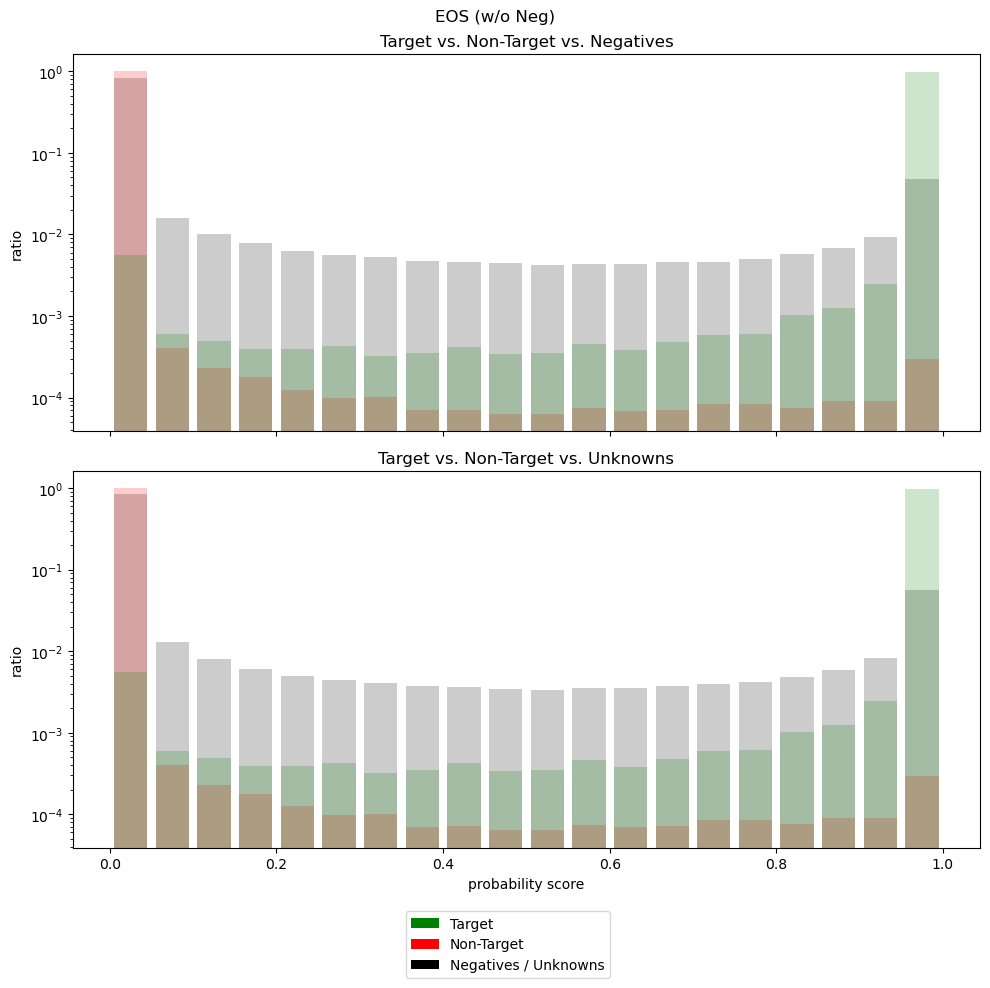

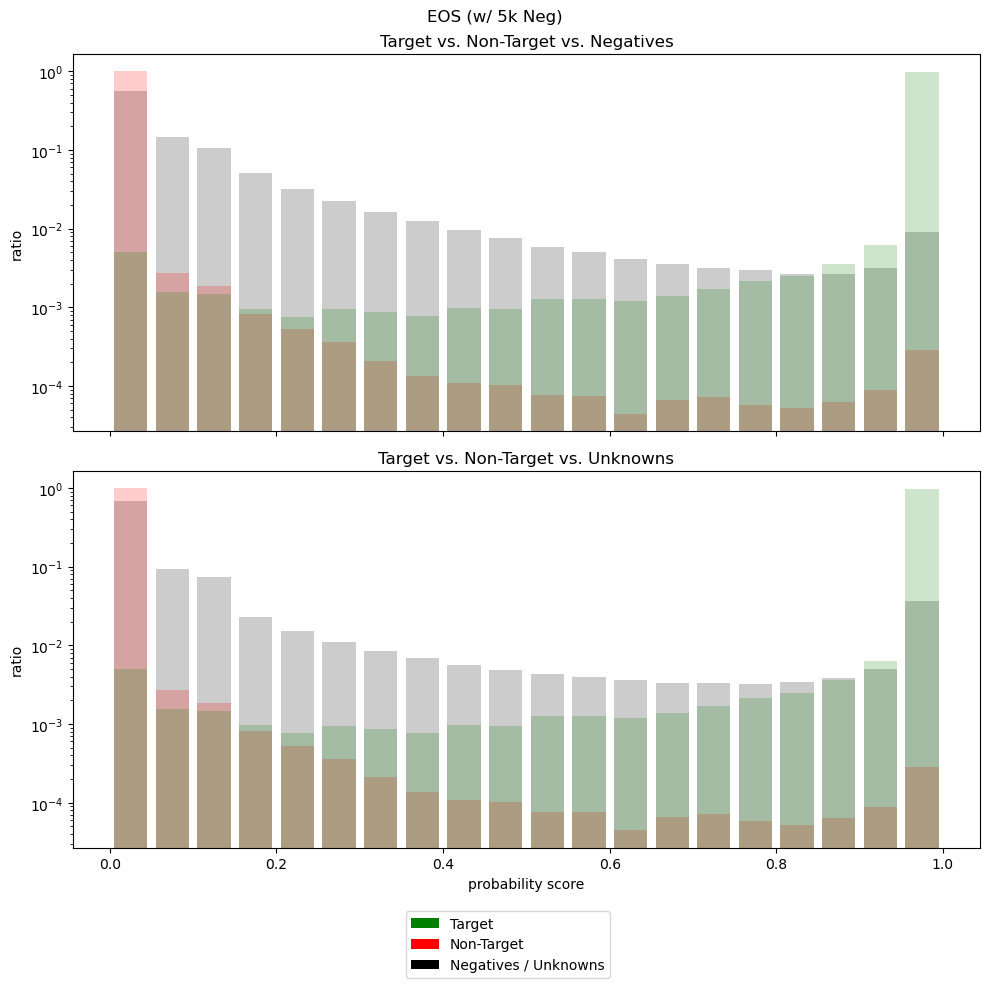

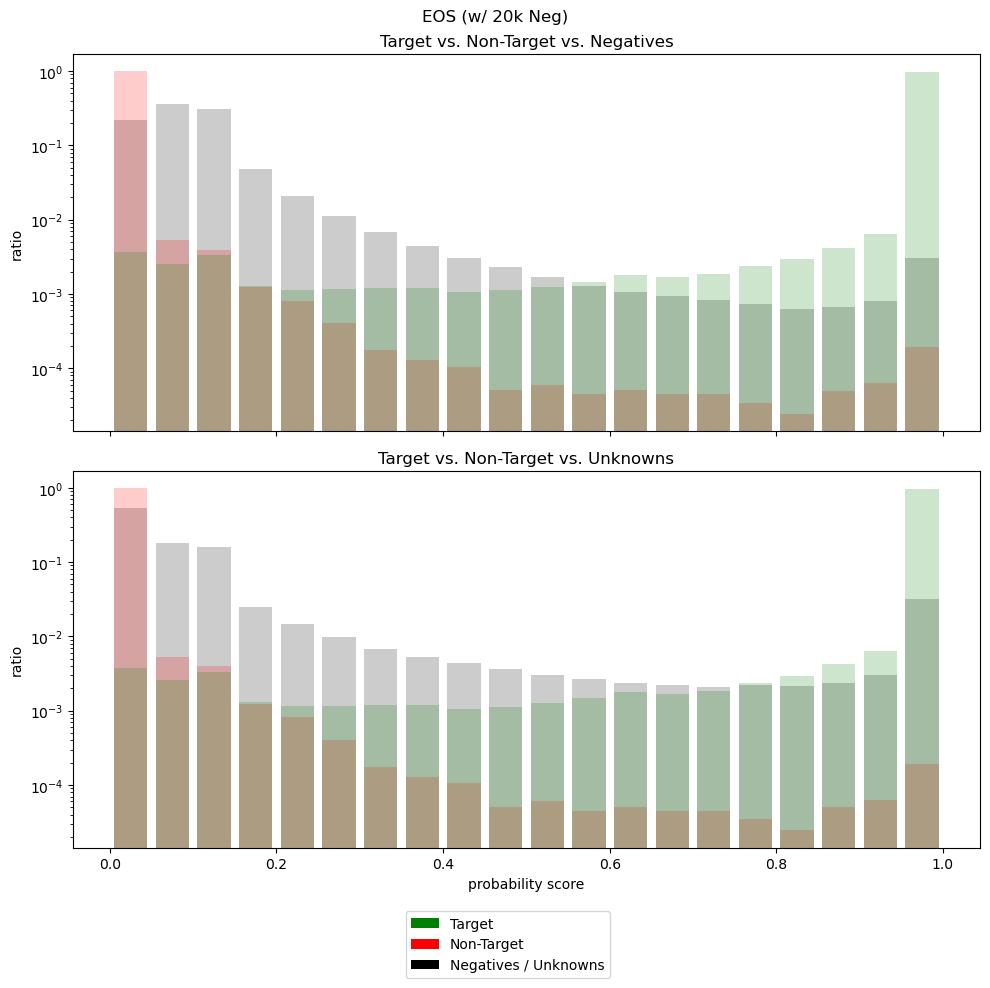

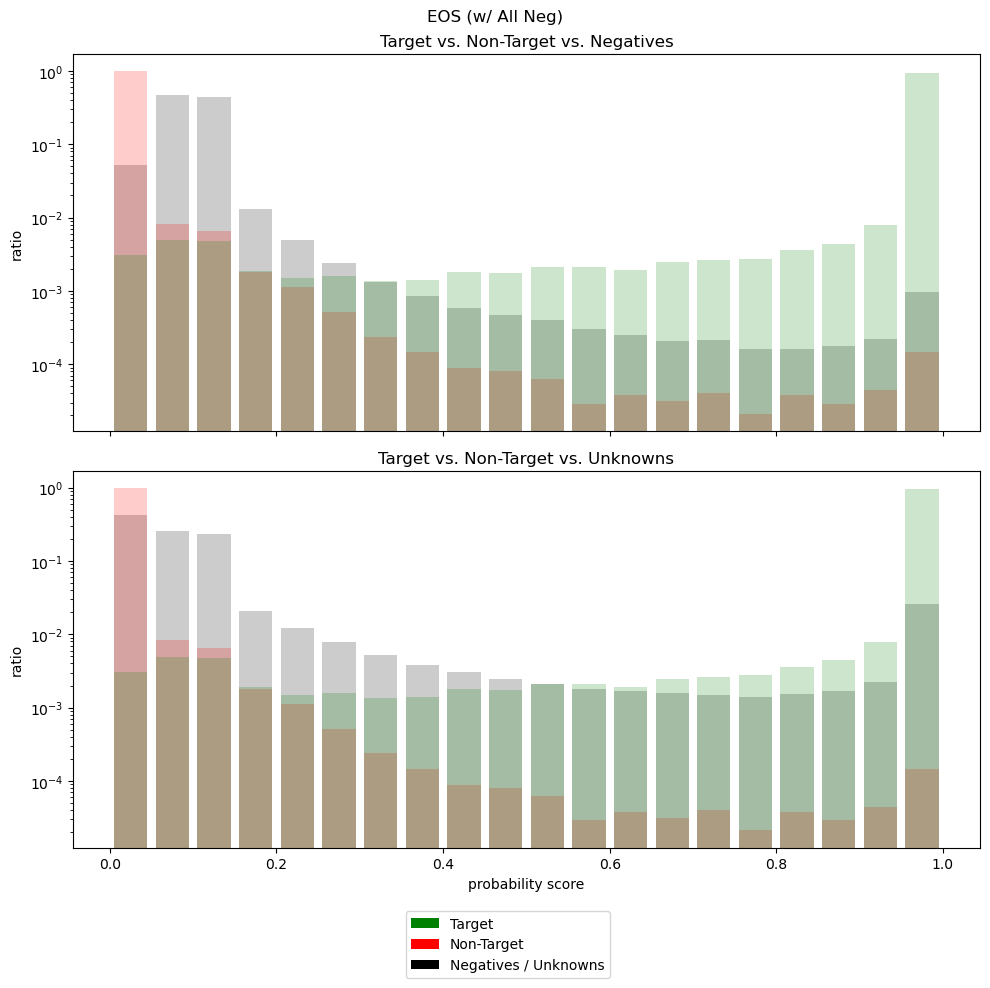

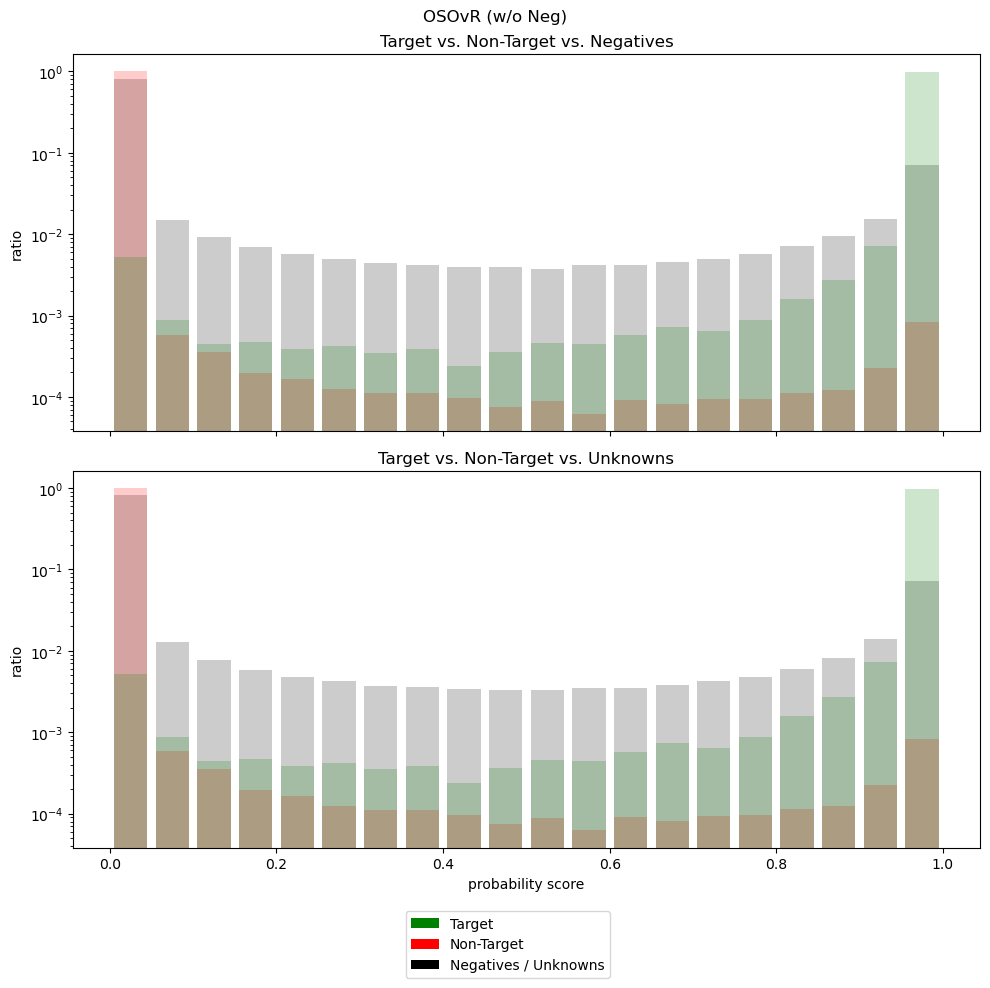

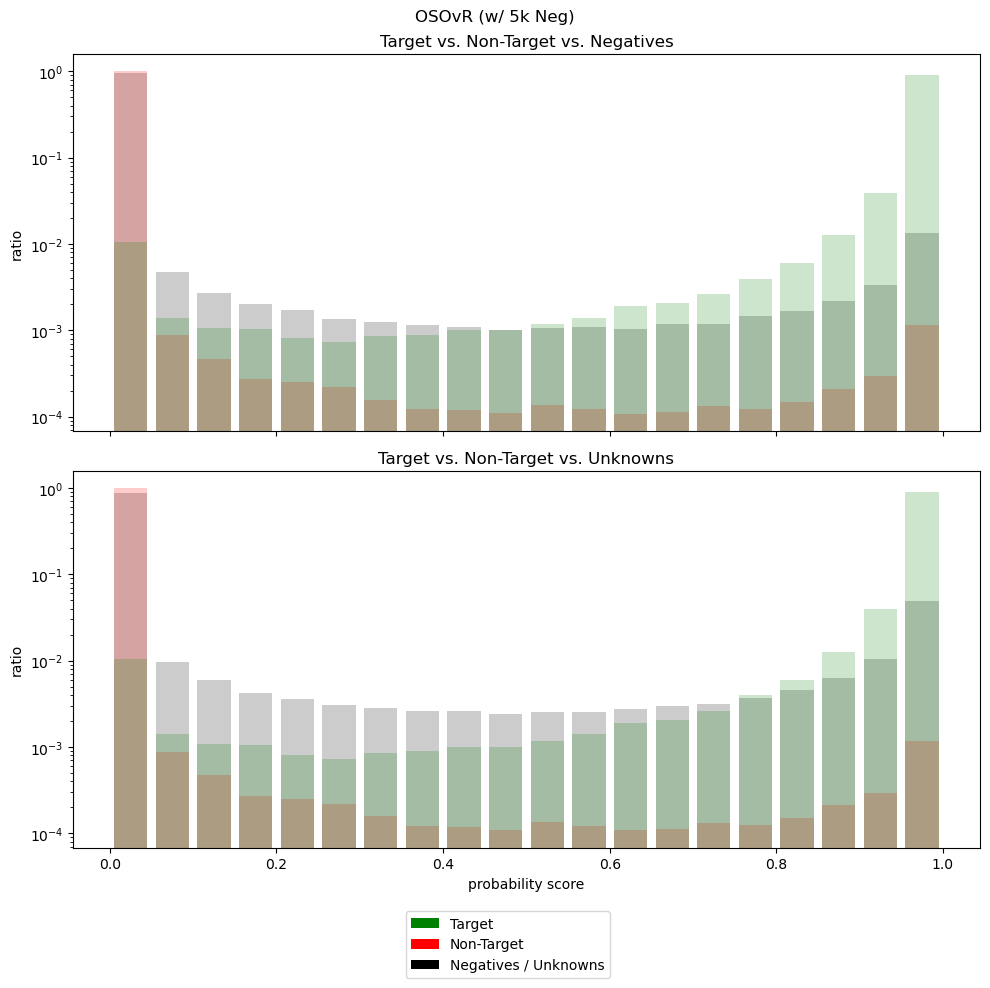

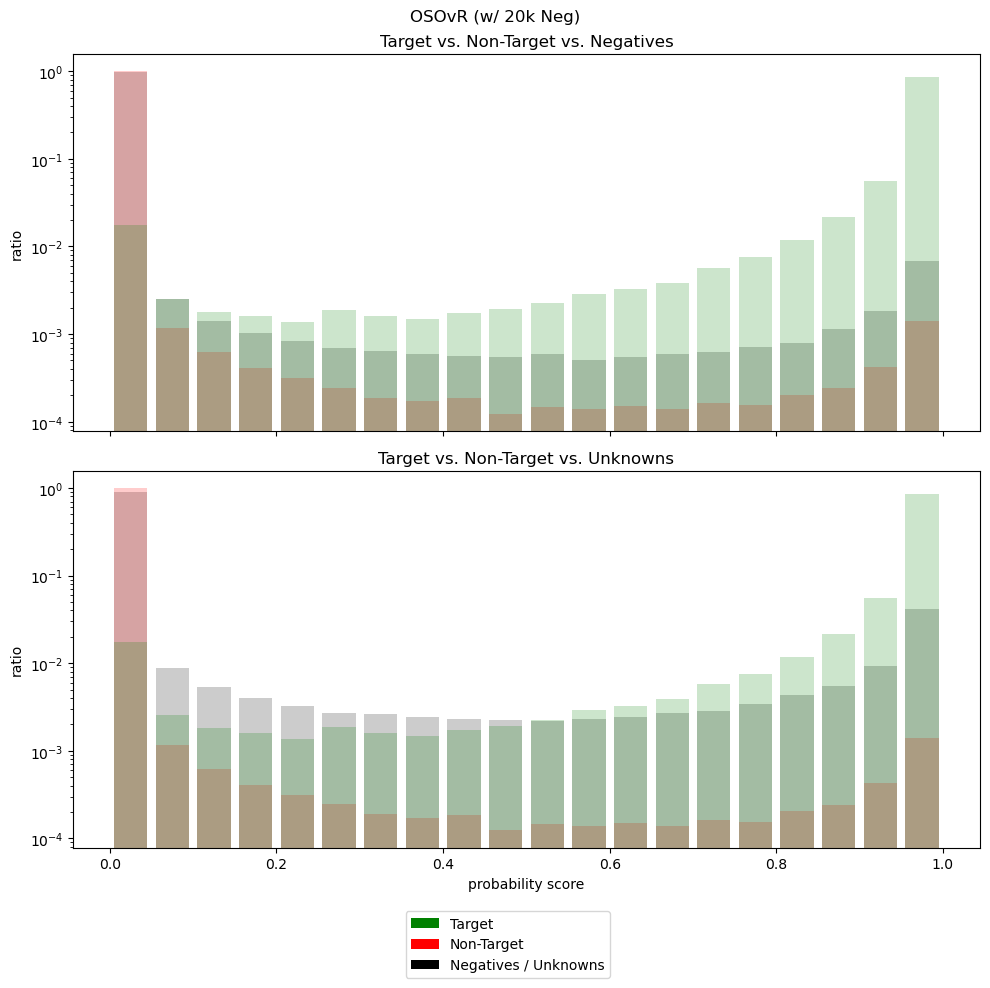

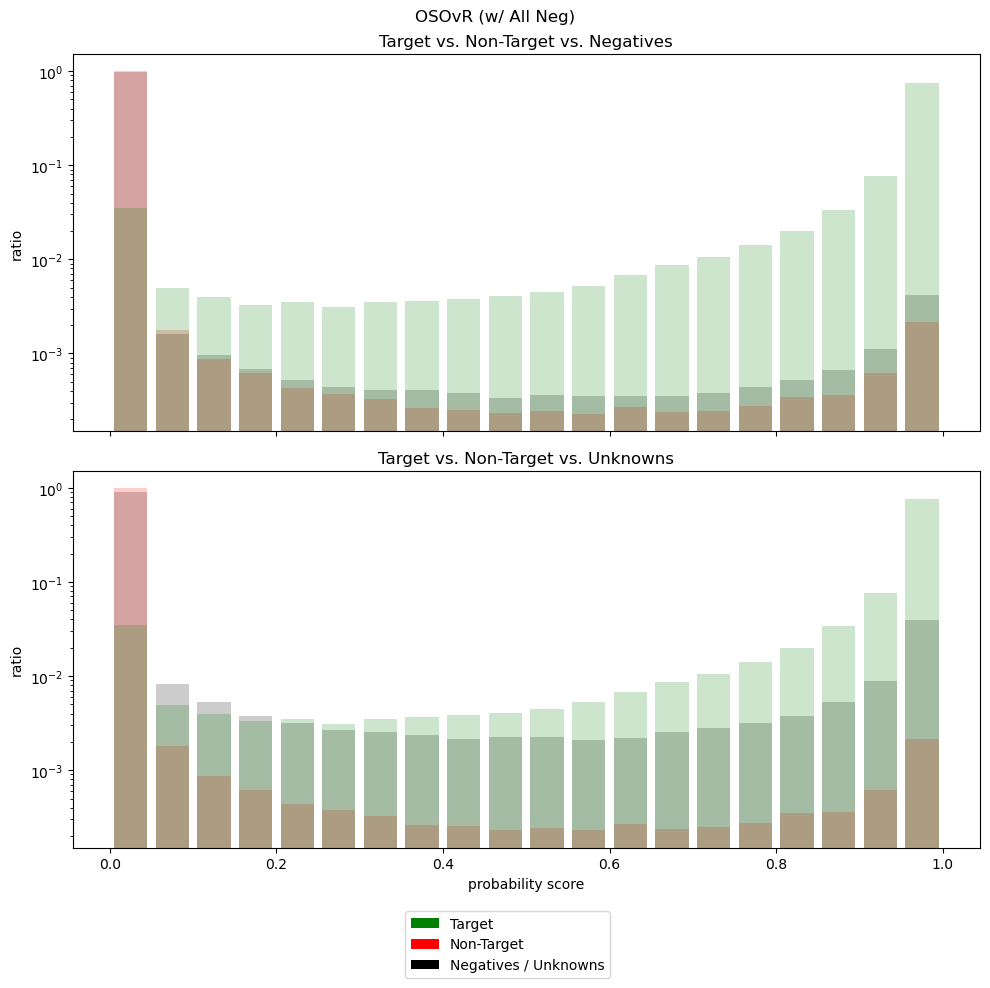

In [91]:
bins = np.linspace(0, 1, 20+1)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
legend_elements = [Patch(facecolor='green', label='Target'), Patch(facecolor='red', label='Non-Target'), Patch(facecolor='black', label='Negatives / Unknowns'),]

for item in data_info:
    fig, ax = plt.subplots(2,1,figsize=(10,10), sharex=True)
    target_probs_all = np.array([])
    non_target_probs_all = np.array([])
    negative_probs_all = np.array([])
    unknown_probs_all = np.array([])
    for c in range(num_classes):
        for s in seeds:

            # Load evaluation results
            folder_path = f"./_results/{item['info'][0]}/_s{s}/eval_{item['info'][1]}/{item['info'][2]}"
            results = eval_results(folder_path)

            # Get known and unknown samples
            knowns = results.test_neg_gt != -1
            negatives = results.test_neg_gt == -1
            unknowns = results.test_unkn_gt == -1

            # Get target and non-target samples
            targets = np.logical_and(knowns, results.test_neg_gt == c)
            non_targets = np.logical_and(knowns, results.test_neg_gt != c)

            # Get probabilities for each item
            target_probs_all = np.append(target_probs_all, results.test_neg_probs[targets,:][:,c])
            non_target_probs_all = np.append(non_target_probs_all, results.test_neg_probs[non_targets,:][:,c])
            negative_probs_all = np.append(negative_probs_all, results.test_neg_probs[negatives,:][:,c])
            unknown_probs_all = np.append(unknown_probs_all, results.test_unkn_probs[unknowns,:][:,c])

    # Get histogram info
    target_probs_all_hist, _ = np.histogram(target_probs_all, bins=bins, density=False)
    non_target_probs_all_hist, _ = np.histogram(non_target_probs_all, bins=bins, density=False)
    negative_probs_all_hist, _ = np.histogram(negative_probs_all, bins=bins, density=False)
    unknown_probs_all_hist, _ = np.histogram(unknown_probs_all, bins=bins, density=False)

    # Change it to ratio between 0 and 1
    target_probs_ratio = target_probs_all_hist/sum(target_probs_all_hist)
    non_target_probs_ratio = non_target_probs_all_hist/sum(non_target_probs_all_hist)
    negative_probs_ratio = negative_probs_all_hist/sum(negative_probs_all_hist)
    unknown_probs_ratio = unknown_probs_all_hist/sum(unknown_probs_all_hist)

    ax[0].bar(center, negative_probs_ratio, align='center', width=width, color = 'black', alpha = 0.2, label='Negatives')
    ax[0].bar(center, non_target_probs_ratio, align='center', width=width, color = 'red', alpha = 0.2, label='Non-Target')
    ax[0].bar(center, target_probs_ratio, align='center', width=width, color = 'green', alpha = 0.2, label='Target')
    ax[0].set_title('Target vs. Non-Target vs. Negatives')
    # ax[0].set_xlabel('probability score')
    ax[0].set_ylabel('ratio')
    ax[0].set_yscale('log')

    ax[1].bar(center, unknown_probs_ratio, align='center', width=width, color = 'black', alpha = 0.2, label='Unknowns')
    ax[1].bar(center, non_target_probs_ratio, align='center', width=width, color = 'red', alpha = 0.2, label='Non-Target')
    ax[1].bar(center, target_probs_ratio, align='center', width=width, color = 'green', alpha = 0.2, label='Target')
    ax[1].set_title('Target vs. Non-Target vs. Unknowns')
    ax[1].set_xlabel('probability score')
    ax[1].set_ylabel('ratio')
    ax[1].set_yscale('log')
    ax[1].legend(handles=legend_elements, bbox_to_anchor=(.6, -.15))

    fig.suptitle(f"{item['label']}")
    fig.tight_layout()

## Confidence progress (or Loss progress)

In [92]:
eos_vs_osovr_data_info = [
    {'info':['SmallScale', 'LeNet_plus_plus_neg0', 'EOS'], 'label': 'EOS (w/o Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[0]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg5k', 'EOS'], 'label': 'EOS (w/ 5k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[2]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg20k', 'EOS'], 'label': 'EOS (w/ 20k Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[4]},
    {'info':['SmallScale', 'LeNet_plus_plus', 'EOS'], 'label': 'EOS (w/ All Neg)', 'linestyle': '--', 'marker': '^', 'color': CMAP[6]},
    {'info':['SmallScale', 'LeNet_plus_plus', 'OpenSetOvR'], 'label': 'OSOvR (w/o Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg5k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 5k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[2]},
    {'info':['SmallScale', 'LeNet_plus_plus_neg20k', 'OpenSetOvR'], 'label': 'OSOvR (w/ 20k Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[4]},
    {'info':['SmallScale', 'LeNet_plus_plus_negAll', 'OpenSetOvR'], 'label': 'OSOvR (w/ All Neg)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[6]},
]

data_info = eos_vs_osovr_data_info


log_item_list = [('Loss/train', 'Loss', 'Training Loss'),
                 ('Loss/val', 'Loss', 'Validation Loss'),
                 ('Acc/train', 'Accuracy', 'Training Acc.'),
                 ('Acc/val', 'Accuracy', 'Validation Acc.'),
                 ('Conf/train_kn', 'Confidence', 'Training Known Confidence.'),
                 ('Conf/train_neg', 'Confidence', 'Training Negative Confidence.'),
                 ('Conf/val_kn', 'Confidence', 'Validation Known Confidence.'),
                 ('Conf/val_neg', 'Confidence', 'Validation Negative Confidence.'),]

for idx, item in enumerate(log_item_list):
    print(f"{idx} : {item[0]}")

0 : Loss/train
1 : Loss/val
2 : Acc/train
3 : Acc/val
4 : Conf/train_kn
5 : Conf/train_neg
6 : Conf/val_kn
7 : Conf/val_neg


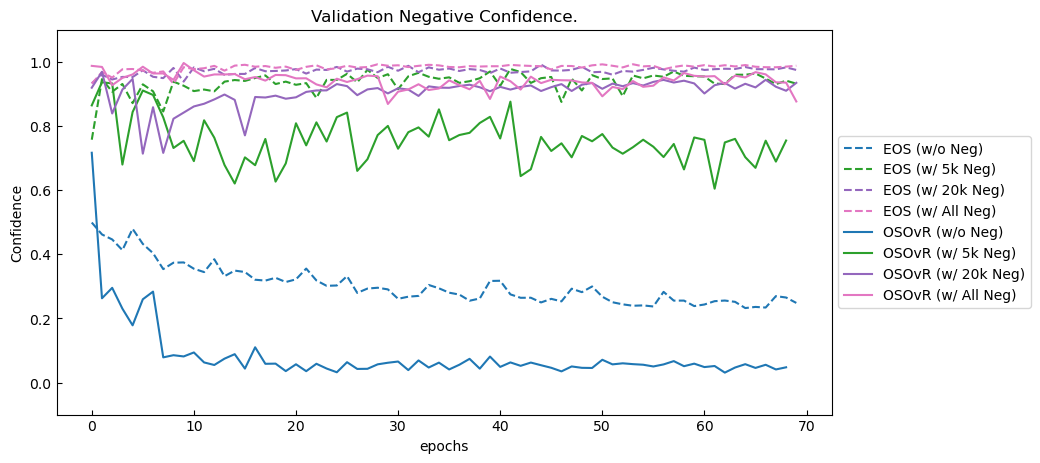

In [93]:
ITEM_IDX = 7

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

plt.figure(figsize=(10,5))
for idx, item in enumerate(data_info):

    logs = get_training_log(item['info'][0], item['info'][1], item['info'][2], log_item)

    plt.plot(logs, label=item['label'], linestyle=item['linestyle'], color=item['color'])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')
